<a href="https://colab.research.google.com/github/MajiroZ/for_git_study/blob/master/ResNet_%26_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install keras
!pip install scikit-image

import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
import gc
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from tensorflow.keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm.notebook import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
import tensorflow.keras.backend as K
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Input
# from keras.models import Model
# from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, SpatialDropout2D
# from keras.layers import concatenate
# from keras.layers import BatchNormalization
# from keras.layers import MaxPooling2D

### Params and helpers

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

### Loading of training/testing ids and depths

Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r "/content/drive/MyDrive/competition_data" /content/

Mounted at /content/drive
^C


In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/competition_data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/content/drive/MyDrive/competition_data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

### Read images and masks

Load the images and masks into the DataFrame and divide the pixel values by 255.

In [5]:
train_df["images"] = [np.array(load_img("/content/drive/MyDrive/competition_data/train/images/{}.png".format(idx), color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [6]:
train_df["masks"] = [np.array(load_img("/content/drive/MyDrive/competition_data/train/masks/{}.png".format(idx), color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

  0%|          | 0/4000 [00:00<?, ?it/s]

### Calculating the salt coverage and salt coverage classes

Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [8]:
def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i :
            return i
    return 0

train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

### Show some example images

Text(0.5, 0.98, 'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

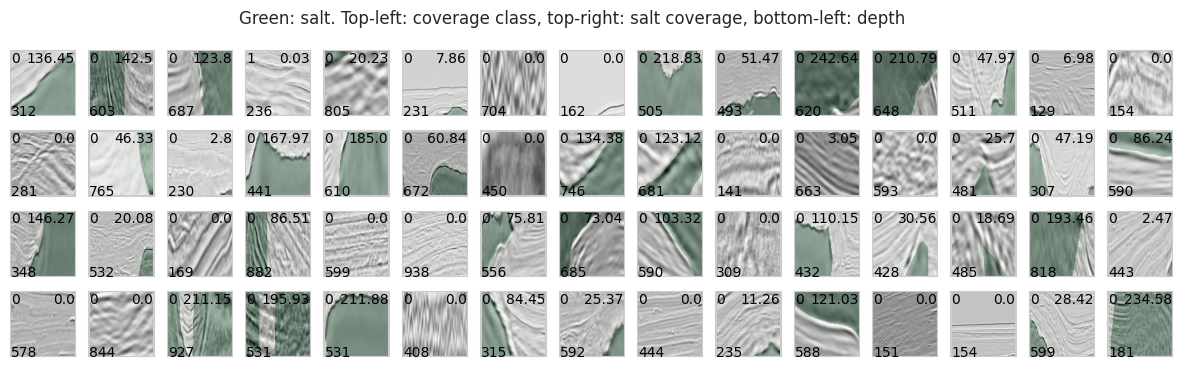

In [9]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

### Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion.Also show an image to check for correct upsampling.

In [10]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5, 1.0, 'Scaled image')

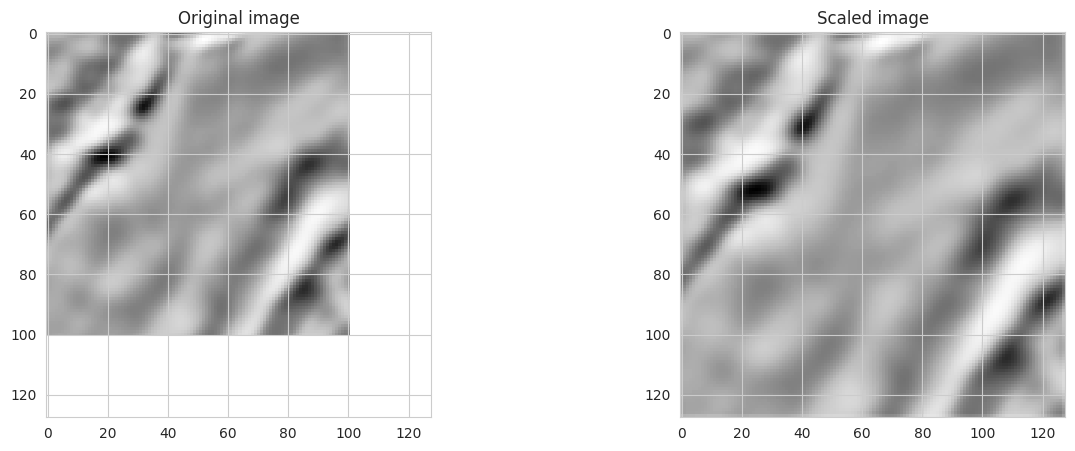

In [11]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

### Build model

In [12]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = BatchNormalization(name=prefix + "_bn")(conv)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

def conv_block_simple_no_bn(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", strides=strides, name=prefix + "_conv")(prevlayer)
    conv = Activation('relu', name=prefix + "_activation")(conv)
    return conv

In [13]:
K.clear_session()
def get_unet_resnet(input_shape):
    resnet_base = ResNet50(input_shape=input_shape, include_top=False)

    for l in resnet_base.layers:
        l.trainable = True
    conv1 = resnet_base.get_layer("activation").output
    conv2 = resnet_base.get_layer("activation_9").output
    conv3 = resnet_base.get_layer("activation_21").output
    conv4 = resnet_base.get_layer("activation_39").output
    conv5 = resnet_base.get_layer("activation_48").output

    up6 = concatenate([UpSampling2D()(conv5), conv4], axis=-1)
    conv6 = conv_block_simple(up6, 256, "conv6_1")
    conv6 = conv_block_simple(conv6, 256, "conv6_2")

    up7 = concatenate([UpSampling2D()(conv6), conv3], axis=-1)
    conv7 = conv_block_simple(up7, 192, "conv7_1")
    conv7 = conv_block_simple(conv7, 192, "conv7_2")

    up8 = concatenate([UpSampling2D()(conv7), conv2], axis=-1)
    conv8 = conv_block_simple(up8, 128, "conv8_1")
    conv8 = conv_block_simple(conv8, 128, "conv8_2")

    up9 = concatenate([UpSampling2D()(conv8), conv1], axis=-1)
    conv9 = conv_block_simple(up9, 64, "conv9_1")
    conv9 = conv_block_simple(conv9, 64, "conv9_2")

    up10 = UpSampling2D()(conv9)
    conv10 = conv_block_simple(up10, 32, "conv10_1")
    conv10 = conv_block_simple(conv10, 32, "conv10_2")
    conv10 = SpatialDropout2D(0.2)(conv10)
    x = Conv2D(1, (1, 1), activation="sigmoid", name="prediction")(conv10)
    model = Model(resnet_base.input, x)

    return model

In [14]:
import warnings

# from keras.applications.imagenet_utils import _obtain_input_shape
import warnings
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
#from keras.engine.topology import get_source_inputs
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.utils import get_file

WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'keras.., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [15]:
def ResNet50(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

#     x = AveragePooling2D((7, 7), name='avg_pool')(x)

#     if include_top:
#         x = Flatten()(x)
#         x = Dense(classes, activation='softmax', name='fc1000')(x)
#     else:
#         if pooling == 'avg':
#             x = GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path,by_name=True)
    return model

In [16]:
def relu6(x):
    return K.relu(x, max_value=6)

In [17]:
# model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)
# model = get_unet_mobilenet(input_shape=(128,128,1))
model = get_unet_resnet(input_shape=(img_size_target,img_size_target,3))

94653016/94653016 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
import tensorflow as tf

thresholds = tf.range(0.5, 1, 0.05, dtype=tf.float32) # 関数の外に移動

@tf.function
def get_iou_vector(A, B):
    # tf.numpy_function を避ける
    A = tf.cast(A, tf.bool)
    B = tf.cast(B, tf.bool)

    intersection = tf.reduce_sum(tf.cast(tf.logical_and(A, B), tf.float32), axis=[1, 2])
    union = tf.reduce_sum(tf.cast(tf.logical_or(A, B), tf.float32), axis=[1, 2])

    iou = (intersection + 1e-10) / (union + 1e-10)

    # thresholds = tf.range(0.5, 1, 0.05, dtype=tf.float32) # 移動済み
    s = tf.map_fn(lambda thresh: tf.greater(iou, thresh), thresholds, fn_output_signature=tf.bool)

    return tf.reduce_mean(tf.cast(s, tf.float32), axis=0)

@tf.keras.utils.register_keras_serializable()
def my_iou_metric(label, pred):
    # Avoid tf.numpy_function
    pred = tf.cast(pred > 0.5, tf.float64)  # 二値化と型変換
    label = tf.cast(label, tf.float64)      # 型を統一
    iou_value = get_iou_vector(label, pred)  # 直接 get_iou_vector を呼ぶ

    # IoUベクトルの平均値を計算
    mean_iou = tf.reduce_mean(iou_value)

    return mean_iou # 平均IoUを返す

def my_iou_metric_2(label, pred):
    pred = tf.cast(pred, tf.float32)
    return tf.numpy_function(
        func=get_iou_vector,
        inp=[label, tf.cast(pred > 0, tf.float64)],
        Tout=tf.float64
    )

In [19]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)  # Use tf.keras.backend.flatten
    y_pred = tf.cast(y_pred, 'float32')  # Use tf.cast
    y_pred_f = tf.cast(tf.greater(tf.keras.backend.flatten(y_pred), 0.5), 'float32')  # Use tf.cast and tf.keras.backend.flatten
    intersection = y_true_f * y_pred_f
    score = 2. * tf.reduce_sum(intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))  # Use tf.reduce_sum
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)  # Use tf.keras.backend.flatten
    y_pred_f = tf.keras.backend.flatten(y_pred)  # Use tf.keras.backend.flatten
    intersection = y_true_f * y_pred_f
    score = (2. * tf.reduce_sum(intersection) + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)  # Use tf.reduce_sum
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) +
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [20]:
import gc
gc.enable()

In [21]:
# モデルの設定
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[my_iou_metric])

In [22]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

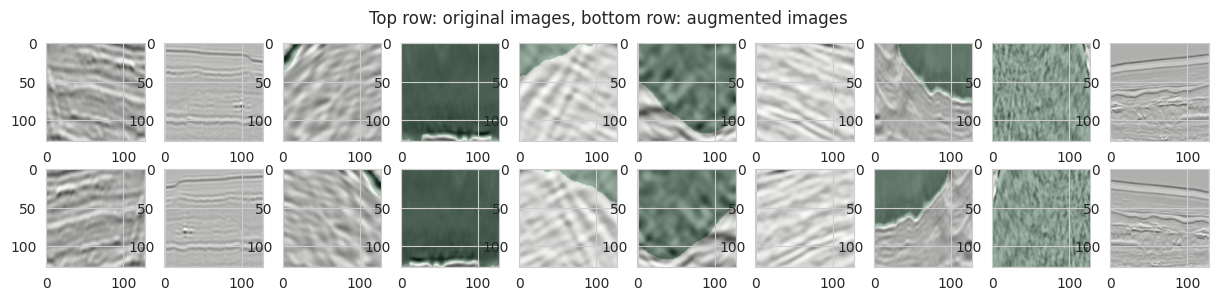

In [23]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [24]:
# 例: データセットのサンプル数を削減
x_train, y_train = x_train[:1000], y_train[:1000]
x_valid, y_valid = x_valid[:200], y_valid[:200]

### Training

In [25]:
# ipython-input-48-dcc7ac27685e
#
# base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights=None)
# x = base_model.output

# x = layers.Conv2DTranspose(1, (2, 2), strides=(32, 32), padding='same', activation='sigmoid')(x)

# Create the model
# model = Model(inputs=base_model.input, outputs=x)

In [26]:
# ipython-input-60-dcc7ac27685e
##
# base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights=None)
# x = base_model.output

# x = layers.UpSampling2D(size=(32, 32))(x)  # Upsample to (batch_size, 128, 128, 2048)

# x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # Resize to (batch_size, 128, 128, 1)

# model = Model(inputs=base_model.input, outputs=x)

In [27]:
# ipython-input-66-dcc7ac27685e
###
# base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights=None)
# x = base_model.output

# Replace UpSampling2D with Conv2DTranspose to control output size
#x = layers.Conv2DTranspose(1, (64, 64), strides=(32, 32), padding='same', activation='sigmoid')(x)  # Resize to (batch_size, 128, 128, 1)

# model = Model(inputs=base_model.input, outputs=x)

In [28]:
base_model = ResNet50(include_top=False, input_shape=(128, 128, 3), weights=None)
x = base_model.output

x = layers.UpSampling2D(size=(32, 32))(x)  # Upsample to (batch_size, 128, 128, 2048)

x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # Resize to (batch_size, 128, 128, 1)

model = Model(inputs=base_model.input, outputs=x)

In [29]:
###
# x = layers.UpSampling2D(size=(32, 32))(x)  # Upsample to (batch_size, 128, 128, 2048)
# x = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)  # Resize to (batch_size, 128, 128, 1)

# model = Model(inputs=base_model.input, outputs=x)

In [30]:
# 3. モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[my_iou_metric])

In [31]:
print("x_train shape:", x_train.shape)
print("x_valid shape:", x_valid.shape)

x_train shape: (1000, 128, 128, 1)
x_valid shape: (200, 128, 128, 1)


In [32]:
model_checkpoint = ModelCheckpoint("./best_model.keras",monitor='val_my_iou_metric',
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 32

x_train = np.repeat(x_train, 3, axis=3)
x_valid = np.repeat(x_valid, 3, axis=3)

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr],shuffle=True,verbose=2)

Epoch 1/100

Epoch 1: val_my_iou_metric improved from -inf to 0.10536, saving model to ./best_model.keras
32/32 - 112s - 3s/step - loss: -8.6029e+03 - my_iou_metric: 0.1804 - val_loss: -3.4883e+04 - val_my_iou_metric: 0.1054 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_my_iou_metric improved from 0.10536 to 0.11384, saving model to ./best_model.keras
32/32 - 17s - 535ms/step - loss: -2.4626e+04 - my_iou_metric: 0.1294 - val_loss: -1.5686e+05 - val_my_iou_metric: 0.1138 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_my_iou_metric did not improve from 0.11384
32/32 - 9s - 273ms/step - loss: -4.4000e+04 - my_iou_metric: 0.1226 - val_loss: -4.2301e+05 - val_my_iou_metric: 0.1138 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_my_iou_metric did not improve from 0.11384
32/32 - 10s - 312ms/step - loss: -7.9172e+04 - my_iou_metric: 0.1211 - val_loss: -1.3919e+06 - val_my_iou_metric: 0.1138 - learning_rate: 0.0010
Epoch 5/100

Epoch 5: val_my_iou_metric did not improve from 0.11384
3

In [33]:
del ids_train, x_train, y_train, cov_train,depth_train,depths_df,depth_test
gc.collect()

12494

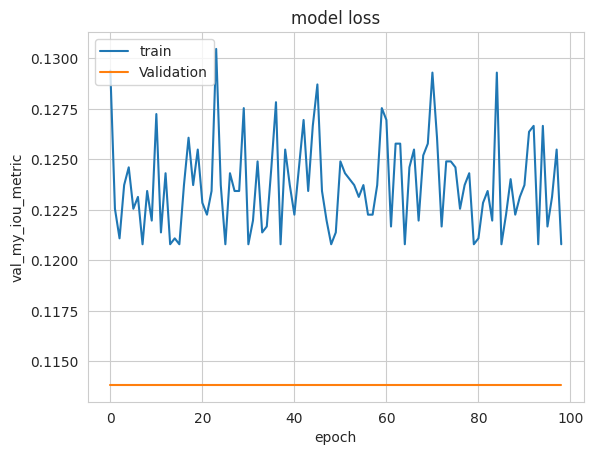

In [34]:
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('model loss')
plt.ylabel('val_my_iou_metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [35]:
model = load_model("./best_model.keras")

### Predict the validation set to do a sanity check

Again plot some sample images including the predictions.

In [36]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test]).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect]).reshape(-1, img_size_target, img_size_target)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [37]:
preds_valid = predict_result(model,x_valid,img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([downsample(x) for x in y_valid])

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 594ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Text(0.5, 0.98, 'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

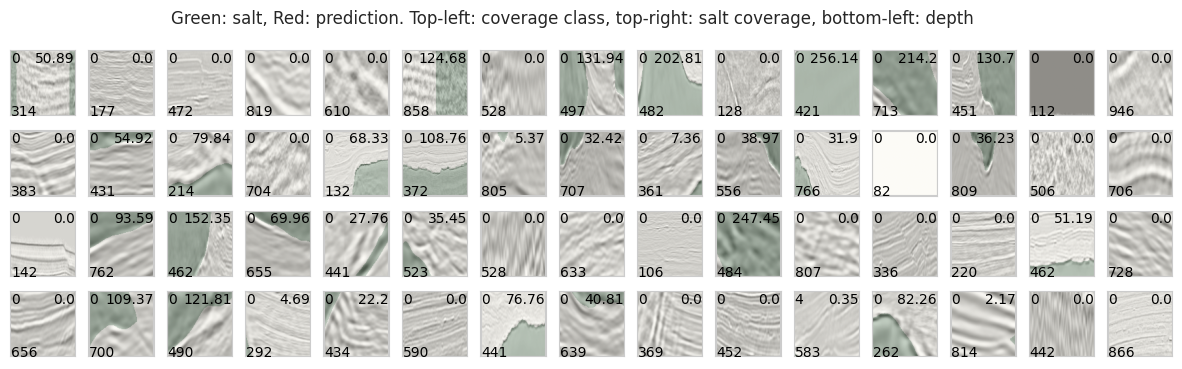

In [38]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

### Scoring

Score the model and do a threshold optimization by the best IoU.

In [39]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [40]:
## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

  0%|          | 0/31 [00:00<?, ?it/s]

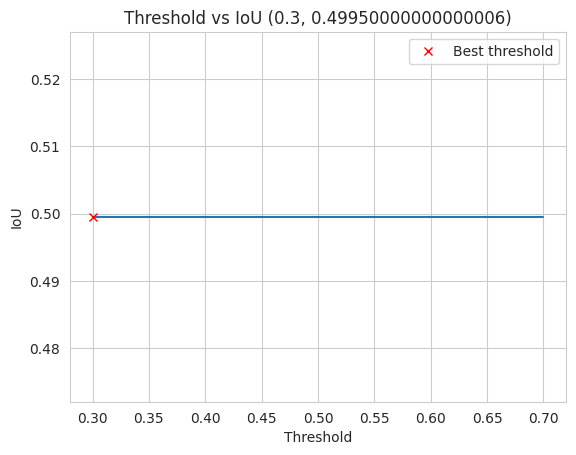

In [41]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [42]:
threshold_best

0.3

### Another sanity check with adjusted threshold

Again some sample images with the adjusted threshold.

Text(0.5, 0.98, 'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

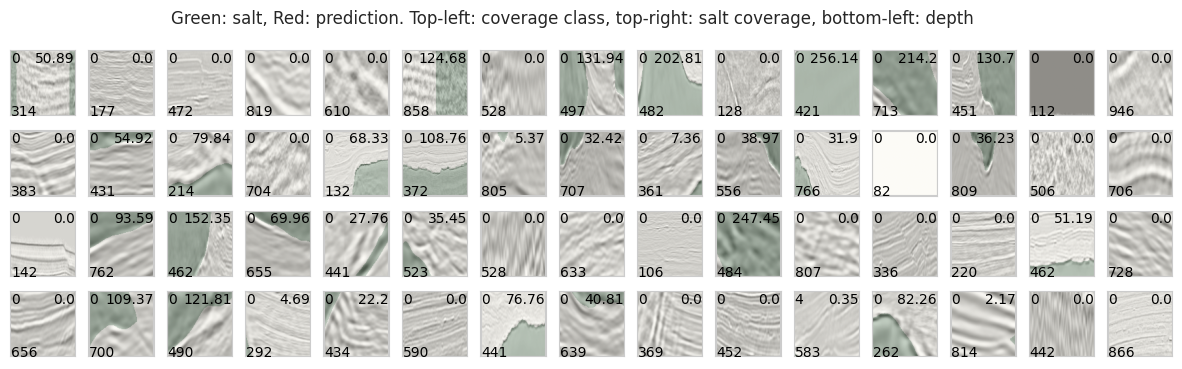

In [43]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

### Submission

Load, predict and submit the test image predictions.

In [44]:
del x_valid, y_valid,preds_valid,y_valid_ori,train_df
gc.collect()

60

In [ ]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

batch_size = 500
preds_test = []
i = 0
while i < test_df.shape[0]:
    print('Images Processed:',i)
    index_val = test_df.index[i:i+batch_size]
    depth_val = test_df.z[i:i+batch_size]
    x_test = np.array([upsample(np.array(load_img("/content/drive/MyDrive/competition_data/test/images/{}.png".format(idx), color_mode='grayscale'))) / 255 for idx in (index_val)]).reshape(-1, img_size_target, img_size_target, 1)
    x_test = np.repeat(x_test,3,axis=3)
    preds_test_temp = predict_result(model,x_test,img_size_target)
    if i==0:
        preds_test = preds_test_temp
    else:
        preds_test = np.concatenate([preds_test,preds_test_temp],axis=0)
#     print(preds_test.shape)
    i += batch_size

Images Processed: 0
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Images Processed: 500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Images Processed: 1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Images Processed: 1500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Images Processed: 2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Images Processed: 2500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Images Processed: 3000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Images Processed: 3500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Images Processed: 4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Images Processed: 4500
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
16/16 ━━━━━━━

In [ ]:
del x_test,preds_test_temp
gc.collect()

In [ ]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('resnet50_pretrained_submission.csv')

##【問題1】コードレビュー